In [43]:
import os
import shutil
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from torchvision.utils import make_grid
from PIL import Image

In [44]:
# User Dataset Path
DATASET_PATH = '/Users/mdtanvirsarwar/Downloads/dataset/archive (1)'

# Output Paths
OUTPUT_DIR = "./COVID_Experiment"
SYNTHETIC_DIR = os.path.join(OUTPUT_DIR, "Synthetic_Images")
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "Weights")

In [45]:
# Hyperparameters
IMG_SIZE = 64
BATCH_SIZE = 32
LATENT_DIM = 100
EPOCHS_GAN = 100
EPOCHS_CNN = 50       # High epochs, will adapt via Early Stopping
LR_GAN = 0.0002
LR_CNN = 0.001
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Classes
CLASSES = ['non-COVID', 'COVID'] # 0, 1

In [46]:
# Ensure directories exist
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR) # Clean start
os.makedirs(SYNTHETIC_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)
for c in CLASSES:
    os.makedirs(os.path.join(SYNTHETIC_DIR, c), exist_ok=True)

print(f"[INFO] Device: {DEVICE}")
print(f"[INFO] Dataset: {DATASET_PATH}")

[INFO] Device: mps
[INFO] Dataset: /Users/mdtanvirsarwar/Downloads/dataset/archive (1)



--- Inspecting Main Dataset ---
Class Distribution: {'non-COVID': 1229, 'COVID': 1252}


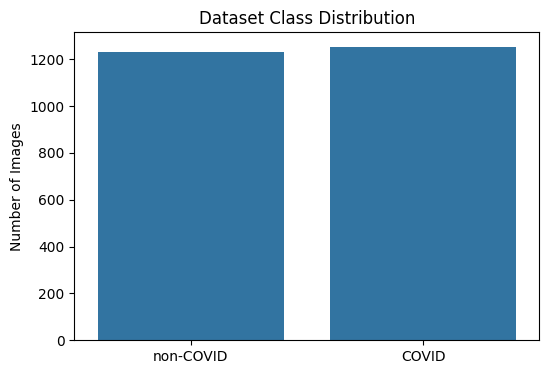


Visualizing Random Samples from Main Dataset:


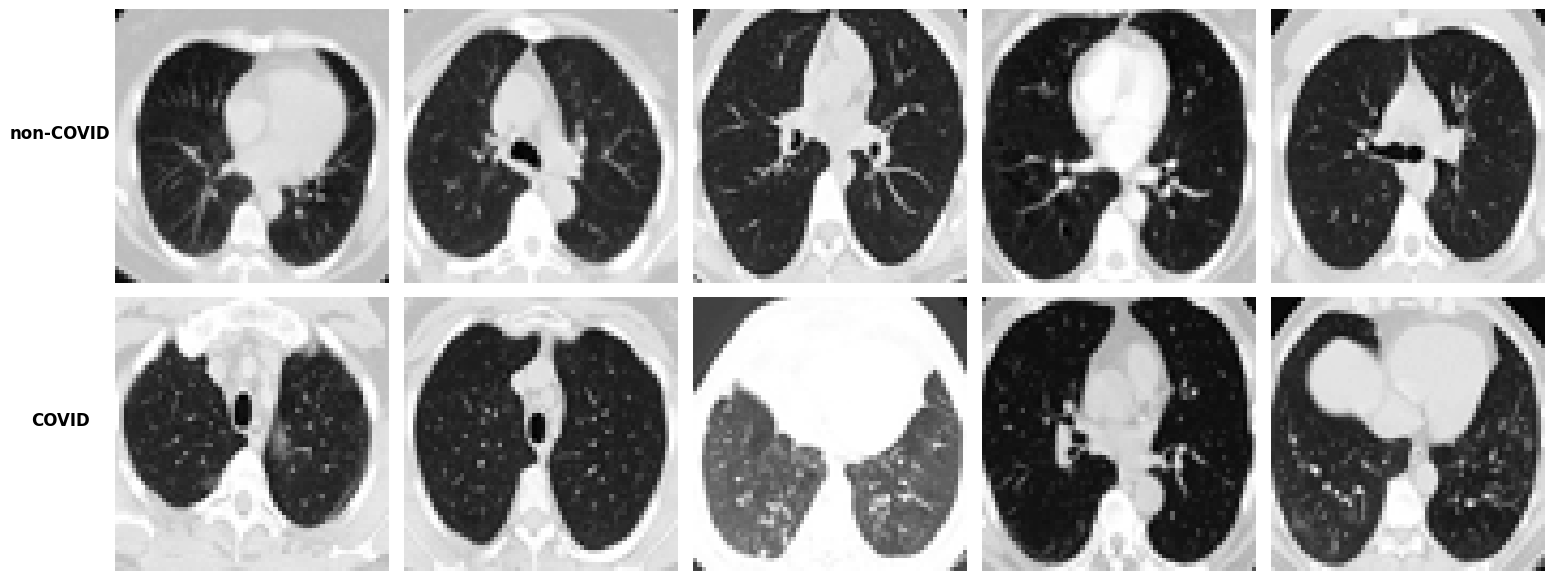

In [47]:
def visualize_dataset(path):
    print("\n--- Inspecting Main Dataset ---")
    if not os.path.exists(path):
        print(f"[ERROR] Path not found: {path}")
        return

    class_counts = {}
    
    # 1. Count Files
    for cls in CLASSES:
        cls_path = os.path.join(path, cls)
        if os.path.exists(cls_path):
            files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[cls] = len(files)
        else:
            class_counts[cls] = 0
            
    print(f"Class Distribution: {class_counts}")
    
    # 2. Plot Distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Dataset Class Distribution")
    plt.ylabel("Number of Images")
    plt.show()

    # 3. Visualize Samples
    print("\nVisualizing Random Samples from Main Dataset:")
    fig, axes = plt.subplots(len(CLASSES), 5, figsize=(15, 3 * len(CLASSES)))
    
    if len(CLASSES) == 1: axes = np.expand_dims(axes, axis=0)

    for i, cls in enumerate(CLASSES):
        cls_path = os.path.join(path, cls)
        if not os.path.exists(cls_path): continue
            
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(files) == 0: continue
            
        num_samples = min(len(files), 5)
        samples = random.sample(files, num_samples)
        
        for j, file_name in enumerate(samples):
            img_path = os.path.join(cls_path, file_name)
            try:
                img = Image.open(img_path).convert('L').resize((IMG_SIZE, IMG_SIZE))
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].axis('off')
                if j == 0: axes[i, j].set_title(cls, fontweight='bold', x=-0.2, y=0.5)
            except: pass
                
    plt.tight_layout()
    plt.show()

visualize_dataset(DATASET_PATH)

In [48]:
# 1. Define Transforms
def get_transforms(augment=False):
    if augment:
        # Classic Augmentation
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        # Standard
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

In [49]:
# 2. Split Data
print("\n--- Splitting Data (Train/Val/Test) ---")
full_dataset = datasets.ImageFolder(root=DATASET_PATH) # Load without transforms first

# Ratios: 70% Train, 15% Validation, 15% Test
total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Total Images:      {total_size}")
print(f"Training Set (70%): {len(train_subset)}")
print(f"Validation Set (15%): {len(val_subset)}")
print(f"Test Set (15%):       {len(test_subset)}")


--- Splitting Data (Train/Val/Test) ---
Total Images:      2481
Training Set (70%): 1736
Validation Set (15%): 372
Test Set (15%):       373


In [50]:
# Helper to wrap subsets with specific transforms
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)
    @property
    def class_to_idx(self):
        return self.subset.dataset.class_to_idx

# Create Static Test/Val sets (No Augmentation needed for evaluation)
val_data = TransformedSubset(val_subset, transform=get_transforms(augment=False))
test_data = TransformedSubset(test_subset, transform=get_transforms(augment=False))

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = IMG_SIZE // 16
        self.l1 = nn.Sequential(nn.Linear(LATENT_DIM, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128), nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128, 0.8), nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8), nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1), nn.BatchNorm2d(32, 0.8), nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, 3, stride=1, padding=1), nn.Tanh(),
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        return self.conv_blocks(out)



In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn: block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        self.adv_layer = nn.Sequential(nn.Flatten(), nn.Linear(128 * 4 * 4, 1), nn.Sigmoid())
    def forward(self, img):
        out = self.model(img)
        return self.adv_layer(out)



In [53]:
class VGG16Classifier(nn.Module):
    def __init__(self):
        super(VGG16Classifier, self).__init__()
        self.vgg = models.vgg16_bn(weights=None)
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(512, 128), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x): return self.vgg(x)

In [54]:
def describe_model(model, model_name):
    print(f"\n{'='*20} {model_name} {'='*20}")
    print(f"Total Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print("-" * 60)
    print(model)
    print("=" * 60)

gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)
vgg = VGG16Classifier().to(DEVICE)

describe_model(gen, "Generator (DCGAN)")
describe_model(disc, "Discriminator (DCGAN)")
describe_model(vgg, "Classifier (VGG16)")


==================== Generator (DCGAN) ====================
Total Trainable Params: 447,681
------------------------------------------------------------
Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(64, 32, kernel_size=(3

In [55]:
def train_cnn(model, train_loader, val_loader, description="Model", patience=8):
    print(f"\n>>> Training CNN ({description})")
    start_time = time.time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR_CNN, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
    
    best_acc = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_CNN):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                output = model(imgs)
                loss = criterion(output, labels)
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = 100 * train_correct / train_total
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        
        scheduler.step(avg_val_acc)
        
        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        print(f"Epoch {epoch+1}/{EPOCHS_CNN} | Train Loss: {avg_train_loss:.4f} | Val Acc: {avg_val_acc:.2f}% | No Imp: {epochs_no_improve}")

        if epochs_no_improve >= patience:
            print(f"[INFO] Early Stopping triggered.")
            break
            
    total_time = time.time() - start_time
    print(f"Result ({description}) Best Acc: {best_acc:.2f}% | Time: {total_time:.2f}s")
    return best_acc, history, model, total_time


In [56]:
def evaluate_model(model, test_loader, title="Evaluation"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.cpu().tolist())
    
    print(f"\n=== {title} Report ===")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.show()



In [57]:
def train_gan(class_name, class_idx, dataset):
    print(f"\n>>> Training GAN for {class_name}")
    weights_path = os.path.join(WEIGHTS_DIR, f"G_{class_name}.pth")
    G = Generator().to(DEVICE)
    
    if os.path.exists(weights_path):
        print(f"[INFO] Found existing weights. Skipping training.")
        G.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        return G

    idx = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    loader = DataLoader(Subset(dataset, idx), batch_size=BATCH_SIZE, shuffle=True)
    D = Discriminator().to(DEVICE)
    adv_loss = nn.BCELoss()
    opt_g = optim.Adam(G.parameters(), lr=LR_GAN, betas=(0.5, 0.999))
    opt_d = optim.Adam(D.parameters(), lr=LR_GAN, betas=(0.5, 0.999))
    
    for epoch in range(EPOCHS_GAN):
        for i, (imgs, _) in enumerate(loader):
            imgs = imgs.to(DEVICE)
            valid = torch.full((imgs.size(0), 1), 0.9, device=DEVICE)
            fake = torch.zeros(imgs.size(0), 1, device=DEVICE)
            
            opt_g.zero_grad()
            z = torch.randn(imgs.shape[0], LATENT_DIM, device=DEVICE)
            g_loss = adv_loss(D(G(z)), torch.ones(imgs.size(0), 1, device=DEVICE))
            g_loss.backward()
            opt_g.step()
            
            opt_d.zero_grad()
            d_loss = (adv_loss(D(imgs), valid) + adv_loss(D(G(z).detach()), fake)) / 2
            d_loss.backward()
            opt_d.step()
            
    torch.save(G.state_dict(), weights_path)
    return G

In [58]:
def generate_synthetic(class_name, num_samples):
    G = Generator().to(DEVICE)
    G.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, f"G_{class_name}.pth"), map_location=DEVICE))
    G.eval()
    save_dir = os.path.join(SYNTHETIC_DIR, class_name)
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, LATENT_DIM, device=DEVICE)
            img = G(z).cpu().squeeze(0)
            transforms.ToPILImage()(img * 0.5 + 0.5).save(os.path.join(save_dir, f"syn_{i}.png"))


In [59]:
def visualize_synthetic_samples():
    print("\n--- Visualizing Synthetic Data Samples ---")
    synth_dataset = datasets.ImageFolder(root=SYNTHETIC_DIR, transform=get_transforms())
    loader = DataLoader(synth_dataset, batch_size=16, shuffle=True)
    try:
        imgs, labels = next(iter(loader))
        grid = make_grid(imgs, nrow=8, normalize=True)
        plt.figure(figsize=(15, 5))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title("Generated Synthetic Samples")
        plt.axis('off'); plt.show()
    except: pass


=== 1. CLASSIC AUGMENTATION TRAINING ===
Training Images: 1736 (Augmented On-The-Fly)

>>> Training CNN (Classic Augmentation)
Epoch 1/50 | Train Loss: 0.5152 | Val Acc: 80.11% | No Imp: 0
Epoch 2/50 | Train Loss: 0.4232 | Val Acc: 88.98% | No Imp: 0
Epoch 3/50 | Train Loss: 0.3795 | Val Acc: 67.74% | No Imp: 1
Epoch 4/50 | Train Loss: 0.3791 | Val Acc: 85.22% | No Imp: 2
Epoch 5/50 | Train Loss: 0.3713 | Val Acc: 86.02% | No Imp: 3
Epoch 6/50 | Train Loss: 0.3406 | Val Acc: 74.73% | No Imp: 4
Epoch 7/50 | Train Loss: 0.2934 | Val Acc: 88.98% | No Imp: 5
Epoch 8/50 | Train Loss: 0.2702 | Val Acc: 88.44% | No Imp: 6
Epoch 9/50 | Train Loss: 0.2711 | Val Acc: 90.05% | No Imp: 0
Epoch 10/50 | Train Loss: 0.2713 | Val Acc: 90.32% | No Imp: 0
Epoch 11/50 | Train Loss: 0.3047 | Val Acc: 89.78% | No Imp: 1
Epoch 12/50 | Train Loss: 0.2444 | Val Acc: 90.59% | No Imp: 0
Epoch 13/50 | Train Loss: 0.2349 | Val Acc: 89.52% | No Imp: 1
Epoch 14/50 | Train Loss: 0.2557 | Val Acc: 91.13% | No Imp: 0

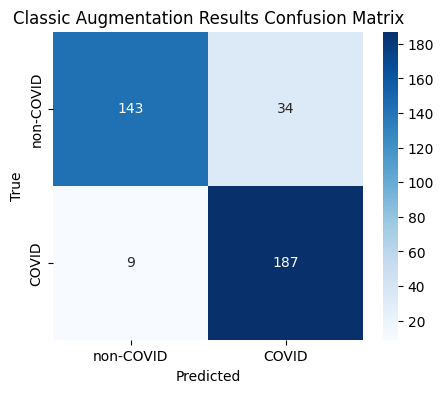

In [60]:
# Create loader with Augmentation Transform
print("\n=== 1. CLASSIC AUGMENTATION TRAINING ===")
train_data_classic = TransformedSubset(train_subset, transform=get_transforms(augment=True))
train_loader_classic = DataLoader(train_data_classic, batch_size=BATCH_SIZE, shuffle=True)

print(f"Training Images: {len(train_data_classic)} (Augmented On-The-Fly)")

classic_model = VGG16Classifier().to(DEVICE)
classic_acc, classic_hist, classic_model, classic_time = train_cnn(
    classic_model, train_loader_classic, val_loader, "Classic Augmentation"
)
evaluate_model(classic_model, test_loader, "Classic Augmentation Results")

In [61]:
print("\n=== 2. GAN TRAINING & GENERATION ===")
# We use the un-augmented training subset for GAN training
train_data_gan = TransformedSubset(train_subset, transform=get_transforms(augment=False))

class_map = full_dataset.class_to_idx
for class_name in CLASSES:
    train_gan(class_name, class_map[class_name], train_data_gan)
    generate_synthetic(class_name, num_samples=1000)

print(f"Generated 1000 synthetic images per class in {SYNTHETIC_DIR}")


=== 2. GAN TRAINING & GENERATION ===

>>> Training GAN for non-COVID

>>> Training GAN for COVID
Generated 1000 synthetic images per class in ./COVID_Experiment/Synthetic_Images



=== 3. GAN AUGMENTATION TRAINING ===
Real: 1736 | Synthetic: 2000 | Total: 3736

>>> Training CNN (GAN Augmentation)
Epoch 1/50 | Train Loss: 0.2768 | Val Acc: 71.51% | No Imp: 0
Epoch 2/50 | Train Loss: 0.1900 | Val Acc: 76.61% | No Imp: 0
Epoch 3/50 | Train Loss: 0.2017 | Val Acc: 80.11% | No Imp: 0
Epoch 4/50 | Train Loss: 0.1718 | Val Acc: 70.70% | No Imp: 1
Epoch 5/50 | Train Loss: 0.1564 | Val Acc: 87.37% | No Imp: 0
Epoch 6/50 | Train Loss: 0.1529 | Val Acc: 61.83% | No Imp: 1
Epoch 7/50 | Train Loss: 0.1079 | Val Acc: 90.05% | No Imp: 0
Epoch 8/50 | Train Loss: 0.1369 | Val Acc: 85.75% | No Imp: 1
Epoch 9/50 | Train Loss: 0.1299 | Val Acc: 92.47% | No Imp: 0
Epoch 10/50 | Train Loss: 0.1108 | Val Acc: 83.33% | No Imp: 1
Epoch 11/50 | Train Loss: 0.1025 | Val Acc: 91.40% | No Imp: 2
Epoch 12/50 | Train Loss: 0.1065 | Val Acc: 92.20% | No Imp: 3
Epoch 13/50 | Train Loss: 0.1129 | Val Acc: 70.16% | No Imp: 4
Epoch 14/50 | Train Loss: 0.0713 | Val Acc: 95.16% | No Imp: 0
Epoch 15/

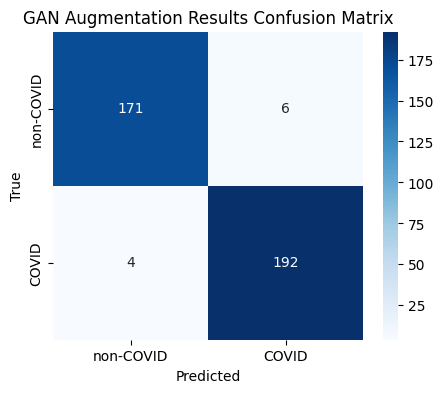

In [62]:
print("\n=== 3. GAN AUGMENTATION TRAINING ===")
synthetic_data = datasets.ImageFolder(root=SYNTHETIC_DIR, transform=get_transforms(augment=False))
train_data_real = TransformedSubset(train_subset, transform=get_transforms(augment=False))
augmented_data = ConcatDataset([train_data_real, synthetic_data])
aug_loader = DataLoader(augmented_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Real: {len(train_data_real)} | Synthetic: {len(synthetic_data)} | Total: {len(augmented_data)}")

aug_model = VGG16Classifier().to(DEVICE)
aug_acc, aug_hist, aug_model, aug_time = train_cnn(
    aug_model, aug_loader, val_loader, "GAN Augmentation"
)
evaluate_model(aug_model, test_loader, "GAN Augmentation Results")



FINAL REPORT:
Classic Augmented Accuracy: 93.28% (Time: 237.9s)
GAN Augmented Accuracy:     97.58% (Time: 532.7s)

[INFO] Displaying generated synthetic samples used for augmentation:


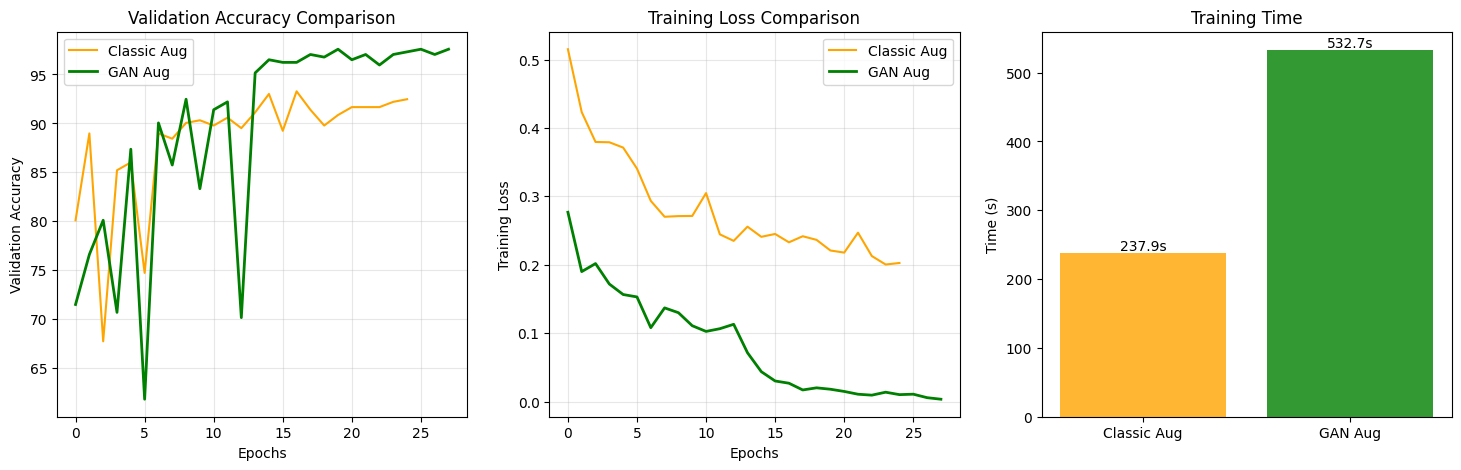

In [63]:
# 6. Comparative Visualization
print("\n========================================")
print(f"FINAL REPORT:")
print(f"Classic Augmented Accuracy: {classic_acc:.2f}% (Time: {classic_time:.1f}s)")
print(f"GAN Augmented Accuracy:     {aug_acc:.2f}% (Time: {aug_time:.1f}s)")
print("========================================")

# --- VISUALIZE SYNTHETIC SAMPLES IN REPORT ---
print("\n[INFO] Displaying generated synthetic samples used for augmentation:")
visualize_synthetic_samples()
# ---------------------------------------------

plt.figure(figsize=(18, 5))

# Accuracy Comparison
plt.subplot(1, 3, 1)
plt.plot(classic_hist['val_acc'], label=f'Classic Aug', color='orange')
plt.plot(aug_hist['val_acc'], label=f'GAN Aug', color='green', linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(classic_hist['train_loss'], label='Classic Aug', color='orange')
plt.plot(aug_hist['train_loss'], label='GAN Aug', color='green', linewidth=2)
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Time Comparison
plt.subplot(1, 3, 3)
methods = ['Classic Aug', 'GAN Aug']
times = [classic_time, aug_time]
colors = ['orange', 'green']
bars = plt.bar(methods, times, color=colors, alpha=0.8)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}s', ha='center', va='bottom')
plt.ylabel('Time (s)')
plt.title('Training Time')
plt.show()